In [1]:
import sys
import os
# Get the absolute path to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# Add it to sys.path
sys.path.append(project_root)

In [2]:
import numpy as np
from bimpcc.dataset import get_dataset
from bimpcc.models.tvqregularized import TVqRegularized
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from bimpcc.utils import generate_2D_gradient_matrices

In [3]:
def plot_experiment(true,noisy,u, alpha):
    
    fig,ax = plt.subplots(1,3,figsize=(14,4))
    ax[0].imshow(true,cmap='gray')
    ax[0].set_title('True Image')
    ax[0].axis('off')
    ax[1].imshow(noisy,cmap='gray')
    ax[1].set_title('Noisy Image\nPSNR: {:.4f}'.format(psnr(true,noisy)))
    ax[1].axis('off')
    ax[2].imshow(u,cmap='gray')
    ax[2].set_title(f'Reconstructed Image\nPSNR: {psnr(true,u):.4f}\n alpha = {alpha}')
    # ax[2].set_xlabel('alpha = {}'.format(alpha))
    ax[2].axis('off')

    plt.show()

In [4]:
scale = 40

In [5]:
dataset = get_dataset("cameraman",scale=scale)
true, noisy = dataset.get_training_data()

(np.float64(-0.5), np.float64(39.5), np.float64(39.5), np.float64(-0.5))

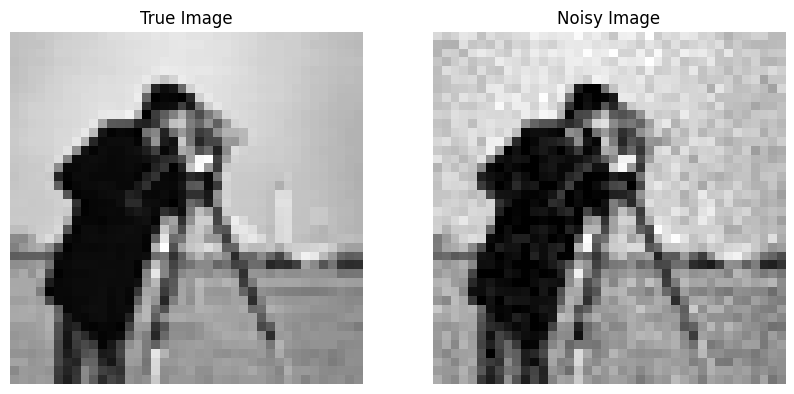

In [6]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(true,cmap='gray')
ax[0].set_title('True Image')
ax[0].axis('off')
ax[1].imshow(noisy,cmap='gray')
ax[1].set_title('Noisy Image')
ax[1].axis('off')

In [ ]:
model = TVqRegularized(true, noisy, epsilon=1e-3, q_param=0.99)

In [8]:
res,x_opt,fun_opt = model.solve(max_iter=3000,tol=1e-4,print_level=5)

/Users/davidvillacis/workspace/bimpcc/bimpcc/utils_tvq.py:123: RuntimeWarning: invalid value encountered in power
  - beta * q_param / normKu * (normKu + (q_param - 1) / gamma) ** (q_param - 1),
/Users/davidvillacis/workspace/bimpcc/bimpcc/utils_tvq.py:166: RuntimeWarning: invalid value encountered in power
  (1 / (normKu**3)) * (normKu + (q_param - 1) / gamma) ** (q_param - 1)
/Users/davidvillacis/workspace/bimpcc/bimpcc/utils_tvq.py:168: RuntimeWarning: invalid value encountered in power
  * (normKu + (q_param - 1) / gamma) ** (q_param - 2)
/Users/davidvillacis/workspace/bimpcc/bimpcc/utils_tvq.py:171: RuntimeWarning: invalid value encountered in power
  e = (beta * delta_gamma) / normKu - (beta * q_param / normKu) * (
/Users/davidvillacis/workspace/bimpcc/bimpcc/utils_tvq.py:179: RuntimeWarning: invalid value encountered in power
  delta_gamma - q_param * (normKu + (q_param - 1) / gamma) ** (q_param - 1)



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:    45722
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     4721
                     variables with only lower bounds:     1601
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4720
Total number of inequality c

KeyboardInterrupt: 

In [37]:
u, q, alpha = model.objective_func.parse_vars(x_opt)

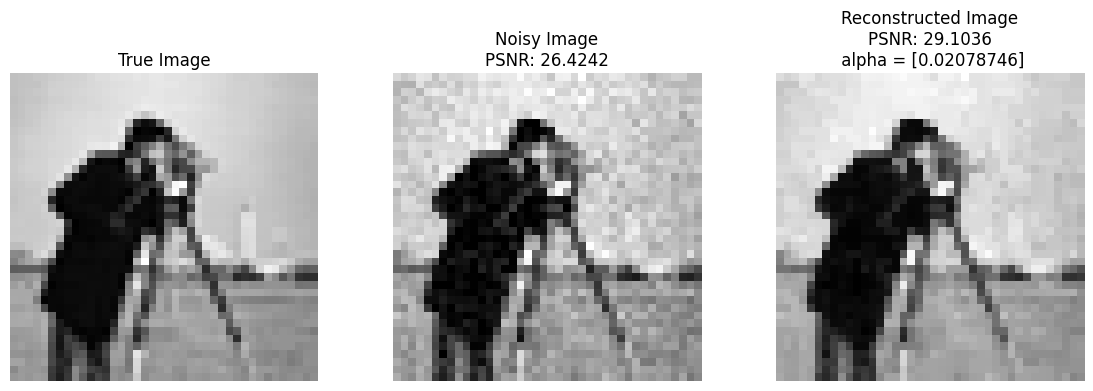

In [38]:
u = u.reshape((scale,scale))
plot_experiment(true,noisy,u,alpha)

In [12]:
Kx, Ky, K = generate_2D_gradient_matrices(scale)

In [13]:
m = q.flatten().size
n = m // 2

Ku = K @ u.flatten()
V = Ku.reshape(2, -1).T
normKu = np.apply_along_axis(np.linalg.norm, axis=1, arr=V)
Q = q.reshape(2,-1).T
normQ = np.apply_along_axis(np.linalg.norm, axis=1, arr=Q)
r0 = normKu
delta0 = normQ

In [14]:
Kxu = Ku[:n]  # Primeras n componentes
Kyu = Ku[n:]  # Últimas n componentes
qx = q[:n]  # Primeras n componentes
qy = q[n:]  # Últimas n componentes
epsilon = 1e-10  

# Condiciones para calcular theta según los casos dados
theta0 = np.zeros(n)  # Inicializamos theta0

# Caso 1: r_i ≠ 0
mask_r_nonzero = r0 > epsilon
theta0[mask_r_nonzero] = np.arccos(Kxu[mask_r_nonzero] / r0[mask_r_nonzero])
theta0[mask_r_nonzero & (Kyu < 0)] *= -1  # Si Ky^i u < 0, negamos theta0

# Caso 2: r_i = 0 y delta_i ≠ 0
mask_r_zero_delta_nonzero = (r0 <= epsilon) & (delta0 > epsilon)
theta0[mask_r_zero_delta_nonzero] = np.arccos(qx[mask_r_zero_delta_nonzero] / delta0[mask_r_zero_delta_nonzero])
theta0[mask_r_zero_delta_nonzero & (qy < 0)] *= -1  # Si qy^i < 0, negamos theta0

# Caso 3: r_i = 0 y delta_i = 0 (theta0 indefinido)
mask_r_zero_delta_zero = (r0 <= epsilon) & (delta0 <= epsilon)
theta0[mask_r_zero_delta_zero] = 0

In [15]:
x0_mpcc = np.concatenate((u.flatten(),q.flatten(),r0,delta0,theta0,alpha))
# print(x0_mpcc)

In [16]:
mpcc_model = TVDenoisingMPCC(true, noisy, x0=x0_mpcc, epsilon=1e-3)

In [18]:
res_mpcc,x_opt_mpcc,fun_opt_mpcc = mpcc_model.solve(max_iter=100,tol=1e-4,print_level=5,verbose=True)

Iter   Termination_status            Objective      MPCC_compl               t

ValueError: too many values to unpack (expected 3)